#Imports

In [ ]:
#Drive mount code (if your're using drive)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


List of a bunch of useful imports

In [ ]:
import cv2
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import os
import plotly.express as px
import math
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


#Ensemble Learning imports
# evaluate gradient boosting algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

#Deep learning imports
import tensorflow as tf
from tensorflow.keras.datasets import mnist  
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt
from tensorflow import keras 
from keras.layers import Activation, Dense
from tensorflow.python.ops.numpy_ops import np_config

#Image Generation Functions
DO NOT RUN

This code is copied from a seperate run time where the images were generated intially

In [ ]:
# Pip install pillow
# Pip install Open-Cv
import string
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import cv2
import os

'''
Returns a list of digits 0-9 followed by a-z and A-Z
'''


def get_letters_list():
    letter_list = list(string.digits)
    letter_list += (list(string.ascii_letters))
    return letter_list


'''
Creates an image of size = size
with background color bgColor
the text of message centered
with the font of font
and the font color = fontColor
'''


def create_image(size, bgColor, message, font, fontColor):
    W, H = size
    image = Image.new('L', size, bgColor)  # L = black and white 8 bit per pixel
    draw = ImageDraw.Draw(image)
    _, _, w, h = draw.textbbox((0, 0), message, font=font)
    draw.text(((W - w) / 2, (H - h) / 2), message, font=font, fill=fontColor)
    return image


'''
Checks and creates the directory in the ./Images folder of the 
entered font and sub directory of its size. 
Then populates the directory with images of size = size
'''


def create_image_folder(size, font):
    font_name = font.getname()[0] + "-" + font.getname()[1]
    relative_dir = "./Images/" + font_name
    size_as_str = str(size[0]) + 'x' + str(size[1])
    font_size = font.size
    if not os.path.exists(relative_dir):
        os.mkdir(relative_dir)
    relative_dir += '/' + size_as_str

    if not os.path.exists(relative_dir):
        os.mkdir(relative_dir)

    for letter in get_letters_list():
        my_image = create_image(size, 'white', letter, font, 'black')
        if str.isdigit(letter):
            save_location = relative_dir + "/" + font_name + '_' + size_as_str + '_digit_' + letter + '_' + str(
                font_size) + '_.png'
        elif str.isupper(letter):
            save_location = relative_dir + "/" + font_name + '_' + size_as_str + '_upper_' + letter + '_' + str(
                font_size) + '_.png'
        else:
            save_location = relative_dir + "/" + font_name + '_' + size_as_str + '_lower_' + letter + '_' + str(
                font_size) + '_.png'
        my_image.save(save_location, 'PNG')


'''
takes and image and returns a donwsampled version
'''


def downsample_image(image_path, size, sample_type):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    lowrez = cv2.resize(image, dsize=(8, 8), interpolation=sample_type)
    return lowrez


'''
Downsamples all images in a folder and adds it to the low resolution images folder
'''


def downsample_folder(directory, new_size):
    size_as_str = str(new_size[0]) + 'x' + str(new_size[1])
    sample_types = [("InterArea", cv2.INTER_AREA), ("InterCubic", cv2.INTER_CUBIC), ("InterLinear", cv2.INTER_LINEAR)]
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            # print(filename)
            split_name = filename.split('_')
            for sample_type in sample_types:
                image = downsample_image(f, new_size, sample_type[1])
                save_location = './Low_Resolution_Images/' + split_name[0] + '_' + split_name[
                    1] + '_to_' + size_as_str + "_" + sample_type[0] + "_" + split_name[2] + "_" + split_name[3] + "_" + \
                                split_name[4] + "_" + split_name[5]
                cv2.imwrite(save_location, image)
            # print(save_location)


'''
mega method to make all the base font images located in the ./Fonts dir
'''


def create_all_fonts():
    letters = get_letters_list()
    image_size = (64, 64)
    font_size = 60

    font_directory = './Fonts'
    for filename in os.listdir(font_directory):
        f = os.path.join(font_directory, filename)
        print(f)
        myFont = ImageFont.truetype(f, font_size)
        create_image_folder(image_size, myFont)

#Loading the raw images into data frames

## Loads the folder of images into a dataframe where image data is all in one col

This version loads the image folder from google drive into a dataframe where the pixel data is stored all in one column as a 2d array. This method turned out to have some issues when trying to format it to train certain models but has been left in incase it is needed later.

In [ ]:
def image_folder_to_dataframe(image_folder_path):  
  font_names = []
  original_res = []
  res = []
  downsample = []
  char_type = []
  char = []
  font_size = []
  image_data = []
  for filename in os.listdir(image_folder_path):
    f_path = os.path.join(image_folder_path, filename)
    split = filename.split('_')
    font_names.append(split[0])
    original_res.append(split[1])
    res.append(split[3])
    downsample.append(split[4])
    char_type.append(split[5])
    char.append(split[6])
    font_size.append(split[7])
    img = Image.open(f_path)
    img_arr = np.array(img)
    # img_arr = img_arr.flatten()
    image_data.append(img_arr)
  d = {"Font_Name": font_names, "Original_Resolution": original_res, "Resolution": res, "Downsample": downsample, "Char_Type": char_type, "Char": char, "Font_Size": font_size, "Image Data": image_data}
  df = pd.DataFrame(data=d)
  return df

## Loads the folder of images into a dataframe where each pixel data is in it's own col

This version loads the image folder from google drive into a data frame where each pixel is stored in it's own column. This version was easier to work with when training the models.

In [ ]:
#I hate this
def image_folder_to_dataframe2(image_folder_path):  

  font_names = []
  original_res = []
  res = []
  downsample = []
  char_type = []
  char = []
  font_size = []
  image_data = []

  for i in range(64):
    image_data.append([])

  for filename in os.listdir(image_folder_path):
    f_path = os.path.join(image_folder_path, filename)
    split = filename.split('_')
    font_names.append(split[0])
    original_res.append(split[1])
    res.append(split[3])
    downsample.append(split[4])
    char_type.append(split[5])
    char.append(split[6])
    font_size.append(split[7])
    img = Image.open(f_path)
    img_arr = np.array(img)
    img_arr = img_arr.flatten()

    for i in range(len(img_arr)):
      image_data[i].append(img_arr[i])

  d = {"Font_Name": font_names, "Original_Resolution": original_res, "Resolution": res, "Downsample": downsample, "Char_Type": char_type, "Char": char, "Font_Size": font_size}

  i = 0
  for row in image_data:
    d[str(i)] = row
    i += 1

  df = pd.DataFrame(data=d)
  for i in range(64):
    df[str(i)] = df[str(i)].astype('uint8')
  return df

##Load the folder of images into a tensor

In [ ]:
def image_folder_to_dataframe2_tensor(image_folder_path):
  font_names = []
  original_res = []
  res = []
  downsample = []
  char_type = []
  char = []
  font_size = []
  image_data = []

  for filename in os.listdir(image_folder_path):
    f_path = os.path.join(image_folder_path, filename)
    split = filename.split('_')
    font_names.append(split[0])
    original_res.append(split[1])
    res.append(split[3])
    downsample.append(split[4])
    char_type.append(split[5])
    char.append(split[6])
    font_size.append(split[7])
    img = Image.open(f_path)
    tensor_img = np.array(img)
    image_data.append(tensor_img)


  d = {"Font_Name": font_names, "Original_Resolution": original_res, "Resolution": res, "Downsample": downsample, "Char_Type": char_type, "Char": char, "Font_Size": font_size, "Image_Data": image_data}


  df = pd.DataFrame(data=d)
  return df

##Testing and creating the data frame

In [ ]:
directory = "/content/drive/MyDrive/Parkside/Machine Learning/Project/Project Image Data/Low_Resolution_Images"
df = image_folder_to_dataframe2(directory)

Test to see if it was working to properly create the dataframe

In [ ]:
df

,Font_Name,Original_Resolution,Resolution,Downsample,Char_Type,Char,Font_Size,0,1,2,...,54,55,56,57,58,59,60,61,62,63
0,Tahoma-Regular,64x64,8x8,InterArea,upper,A,60,255,255,255,...,255,255,255,200,170,255,255,118,245,255
1,Rockwell-Regular,64x64,8x8,InterCubic,lower,j,60,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,Rockwell-Regular,64x64,8x8,InterCubic,lower,a,60,255,255,255,...,255,255,255,255,254,0,255,128,255,255
3,Ti86pc-Regular,64x64,8x8,InterLinear,lower,i,60,255,255,255,...,255,255,255,255,255,255,196,255,255,255
4,Palatino Linotype-Regular,64x64,8x8,InterCubic,lower,q,60,255,255,255,...,255,255,255,255,255,255,111,14,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,Century Schoolbook-Regular,64x64,8x8,InterCubic,upper,V,60,255,255,255,...,255,255,255,255,255,254,255,255,255,255
3902,Arial-Regular,64x64,8x8,InterArea,upper,N,60,255,255,255,...,242,255,255,238,207,255,255,178,250,255
3903,Century Schoolbook-Regular,64x64,8x8,InterArea,lower,i,60,255,255,255,...,255,255,255,255,255,146,154,255,255,255
3904,Adobe Hebrew-Regular,64x64,8x8,InterCubic,digit,1,60,255,255,255,...,255,255,255,255,255,255,255,255,255,255


##Saving the dataframe to a csv
Save dataset to csv to speed up loading the images for the next time

In [ ]:
df.to_csv("/content/drive/MyDrive/Parkside/Machine Learning/Project/Project Image Data/CharImageFile.csv")

In [ ]:
def load_csv_to_correctly_formated_df(csv_file_path):
  df = pd.read_csv(csv_file_path, index_col = 0)
  return df

Load the saved CSV file

Loading the CSV instead of the image data speeds up time to get the dataframe set up and neatly keeps all our data in one file instead of about 4,000 individual images.

In [ ]:
df = load_csv_to_correctly_formated_df("/content/drive/MyDrive/Parkside/Machine Learning/Project/Project Image Data/CharImageFile.csv")

Test to see if it loaded properly

In [ ]:
df

,Font_Name,Original_Resolution,Resolution,Downsample,Char_Type,Char,Font_Size,0,1,2,...,54,55,56,57,58,59,60,61,62,63
0,Tahoma-Regular,64x64,8x8,InterArea,upper,A,60,255,255,255,...,255,255,255,200,170,255,255,118,245,255
1,Rockwell-Regular,64x64,8x8,InterCubic,lower,j,60,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,Rockwell-Regular,64x64,8x8,InterCubic,lower,a,60,255,255,255,...,255,255,255,255,254,0,255,128,255,255
3,Ti86pc-Regular,64x64,8x8,InterLinear,lower,i,60,255,255,255,...,255,255,255,255,255,255,196,255,255,255
4,Palatino Linotype-Regular,64x64,8x8,InterCubic,lower,q,60,255,255,255,...,255,255,255,255,255,255,111,14,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,Century Schoolbook-Regular,64x64,8x8,InterCubic,upper,V,60,255,255,255,...,255,255,255,255,255,254,255,255,255,255
3902,Arial-Regular,64x64,8x8,InterArea,upper,N,60,255,255,255,...,242,255,255,238,207,255,255,178,250,255
3903,Century Schoolbook-Regular,64x64,8x8,InterArea,lower,i,60,255,255,255,...,255,255,255,255,255,146,154,255,255,255
3904,Adobe Hebrew-Regular,64x64,8x8,InterCubic,digit,1,60,255,255,255,...,255,255,255,255,255,255,255,255,255,255


#KNN modeling

##Helper Defs
A bunch of functions that are useful for modeling


In [ ]:
knn = KNeighborsClassifier()

This function splits the data frame from the image data and other meta data into seperate data frames

In [ ]:
def DataFrameImageDataSplit(df):
  imageDataDf = pd.DataFrame(df)
  imageDataDf = imageDataDf.drop(['Font_Name','Original_Resolution','Resolution','Downsample','Char_Type','Font_Size','Char'],axis=1)
  
  dataDf = pd.DataFrame(df)
  dataDf = dataDf.drop(dataDf.columns[7:], axis=1)
  return imageDataDf, dataDf

This function allows us to quickly grab subsets of the data frame based off a vaule

In [ ]:
def grabRowsBasedOnColumnData(df, columnName, columnValue):
  # print((columnName + " == '" + columnValue + "'"))
  df = df.query((columnName + " == '" + columnValue + "'"))
  return df

In [ ]:
from sklearn.metrics import accuracy_score

def getAccuracy(x,y):
  return accuracy_score(x,y)

Function to build and run a KNN model using the default train test split

In [ ]:
from sklearn.metrics import classification_report

def runKNN(df, k):
  imageDataDf, dataDf = DataFrameImageDataSplit(df)
  X_train,Y_train,X_test,Y_test = train_test_split(imageDataDf,dataDf['Char'])
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X=X_train, y=X_test)

  predictions = knn.predict(Y_train)
  actual = Y_test.array

#Uncomment to print predicted value next to actual value
  # for i,_ in enumerate(predictions):
  #   if (predictions[i] != actual[i]):
  #     print("Prediction: ",predictions[i]," ::: Actual: ",actual[i])
  print(classification_report(predictions, actual))

In [ ]:
import string
def get_letters_list():
    letter_list = list(string.digits)
    letter_list += (list(string.ascii_uppercase))
    letter_list += (list(string.ascii_lowercase))
    return letter_list

In [ ]:
def create_confustion_matrix(actual, predictions):
  # chars = get_letters_list()
  chars = df['Char'].unique()
  confusion = confusion_matrix(actual, predictions)
  confusion_df = pd.DataFrame(confusion, index=chars, columns=chars)
  # print(confusion_df)
  for i,_ in enumerate(predictions):
    if (predictions[i] == '0' and actual[i] != "0"):
      print("Prediction: ",predictions[i]," ::: Actual: ",actual[i])
  fig, ax = plt.subplots(figsize=(30,30)) 
  axes = sns.heatmap(confusion_df, annot=True, ax = ax)

##Peliminary KNN models

Using the runKNN function defined above we ran some models with a default k=5 value on our data set and subsets of the dataset with individual downsampling techniques.

Because we are focusing on low resolution text it is important to test mutiple types of downsampling techniques because in a real world senario the way text may have been downsampled can vary from programs used to rescale images. 

A comparison of openCV downsampling libraries can be read here: 
https://gist.github.com/georgeblck/e3e0274d725c858ba98b1c36c14e2835


An explanation on how some of these downsampling technquies are being preformed can be read here: https://medium.com/@wenrudong/what-is-opencvs-inter-area-actually-doing-282a626a09b3

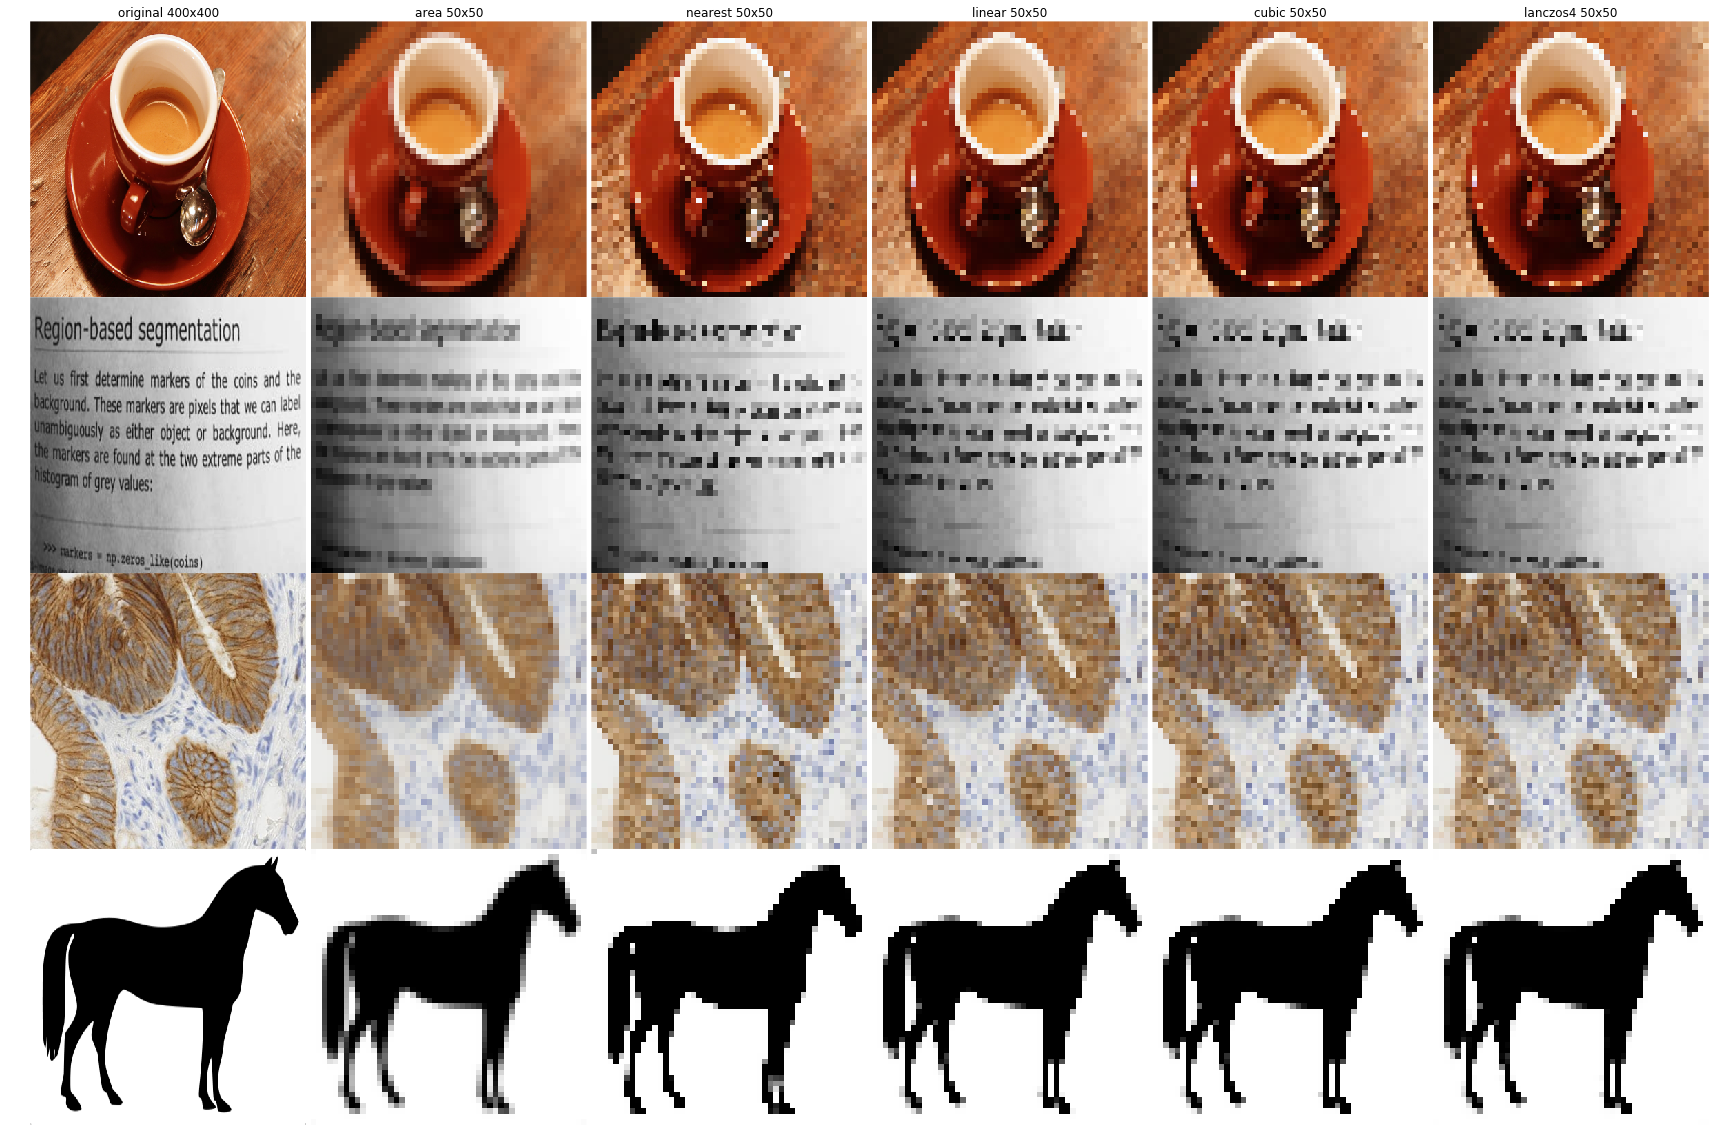

###All Downsampling Methods


In [ ]:
# imageDataDf, dataDf = DataFrameImageDataSplit(df)
runKNN(df, 5)

              precision    recall  f1-score   support

           0       0.53      0.32      0.40        25
           1       0.21      0.36      0.27        11
           2       0.71      0.38      0.50        13
           3       0.88      0.83      0.86        18
           4       0.94      0.94      0.94        18
           5       0.57      0.73      0.64        11
           6       0.92      0.73      0.81        15
           7       0.72      0.81      0.76        16
           8       0.56      0.75      0.64        12
           9       0.68      1.00      0.81        13
           A       0.89      1.00      0.94        16
           B       0.60      0.86      0.71         7
           C       0.82      0.78      0.80        18
           D       0.88      0.58      0.70        24
           E       0.61      0.69      0.65        16
           F       0.70      0.47      0.56        15
           G       0.69      0.75      0.72        12
           H       0.87    

###Inter Area Only

In [ ]:
newDf = grabRowsBasedOnColumnData(df, 'Downsample', 'InterArea')

runKNN(newDf, 5)

              precision    recall  f1-score   support

           0       0.80      0.27      0.40        15
           1       0.33      0.40      0.36         5
           2       0.50      0.80      0.62         5
           3       1.00      0.33      0.50         6
           4       1.00      1.00      1.00         5
           5       0.50      0.67      0.57         3
           6       1.00      0.75      0.86         4
           7       0.80      0.80      0.80         5
           8       1.00      0.60      0.75         5
           9       0.80      1.00      0.89         4
           A       1.00      1.00      1.00         6
           B       0.60      1.00      0.75         6
           C       1.00      1.00      1.00         4
           D       0.80      1.00      0.89         4
           E       0.80      0.67      0.73         6
           F       0.80      0.67      0.73         6
           G       0.50      0.75      0.60         4
           H       0.80    

###Inter Linear Only

In [ ]:
newDf = grabRowsBasedOnColumnData(df, 'Downsample', 'InterLinear')

runKNN(newDf, 5)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.75      0.21      0.33        14
           2       1.00      0.17      0.29         6
           3       0.20      0.20      0.20         5
           4       0.83      0.83      0.83         6
           5       0.00      0.00      0.00         2
           6       0.33      0.50      0.40         4
           7       0.56      0.62      0.59         8
           8       0.29      0.67      0.40         3
           9       0.38      1.00      0.55         3
           A       0.71      0.62      0.67         8
           B       0.67      0.40      0.50         5
           C       0.83      1.00      0.91         5
           D       0.38      1.00      0.55         3
           E       0.50      0.20      0.29         5
           F       0.00      0.00      0.00         2
           G       0.20      0.33      0.25         3
           H       0.80    

###Inter Cubic Only

In [ ]:
newDf = grabRowsBasedOnColumnData(df, 'Downsample', 'InterCubic')

runKNN(newDf, 5)

              precision    recall  f1-score   support

           0       0.75      0.18      0.29        17
           1       0.33      0.14      0.20         7
           2       0.60      0.38      0.46         8
           3       1.00      0.20      0.33        10
           4       0.80      1.00      0.89         4
           5       0.33      0.17      0.22         6
           6       0.38      0.38      0.38         8
           7       0.60      0.75      0.67         4
           8       0.00      0.00      0.00         4
           9       0.50      0.43      0.46         7
           A       1.00      0.83      0.91         6
           B       0.00      0.00      0.00         0
           C       0.43      0.75      0.55         4
           D       0.75      0.60      0.67         5
           E       0.20      0.20      0.20         5
           F       0.00      0.00      0.00         5
           G       0.17      0.33      0.22         3
           H       0.67    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Thoughts from intial models



##Better Train Test Split
Instead of using the default Sklearn train test split that randomly splits the data, instead we want to split the data into train test sets where the distribution of the letters are equal so each letter has the same number of samples. To do this we implement a method that randomly splits the data in train test sets of entire fonts. Selects an N number of entire fonts for training and an N number of entire fonts for testing.

List font names

In [ ]:
df['Font_Name'].unique()

array(['Tahoma-Regular', 'Rockwell-Regular', 'Ti86pc-Regular',
       'Palatino Linotype-Regular', 'Adobe Kaiti Std-R',
       'Segoe UI Emoji-Regular', 'Perpetua-Regular',
       'Bookman Old Style-Regular', 'Candara-Regular', 'Cambria-Regular',
       'Georgia-Regular', 'Arial-Regular', 'Adobe Arabic-Regular',
       'Adobe Caslon Pro-Regular', 'Adobe Hebrew-Regular',
       'Courier New-Regular', 'Century Schoolbook-Regular',
       'Century-Regular', 'Consolas-Regular', 'Adobe Devanagari-Regular',
       'Times New Roman-Regular'], dtype=object)

Test method

In [ ]:
#how to get a specific colum
# Arial_df = df.loc[df['Font Name'] == 'Arial']
One_font_df = grabRowsBasedOnColumnData(df, 'Font_Name', 'Arial')
One_font_df

,Font_Name,Original_Resolution,Resolution,Downsample,Char_Type,Char,Font_Size,0,1,2,...,54,55,56,57,58,59,60,61,62,63


Function to get a random 1 font dataframe

In [ ]:
import random
def getRandomFontDf(num_fonts):
  font_names = df['Font_Name'].unique()
  font_names = font_names.tolist()
  return_df = pd.DataFrame()
  for i in range(num_fonts):
    font_index = random.randint(0, len(font_names)-1)
    font = font_names.pop(font_index)
    return_df = return_df.append(grabRowsBasedOnColumnData(df, 'Font_Name', font))
  return return_df

###New Train Test Split method

In [ ]:
def better_train_test_split(df, num_fonts):
    train = pd.DataFrame(df)
    test = pd.DataFrame()
    test_fonts = []
    font_names = df['Font_Name'].unique()
    font_names = font_names.tolist()
    for i in range(num_fonts):
      font_index = random.randint(0, len(font_names)-1)
      font = font_names.pop(font_index)
      test_fonts.append(font)
      test = test.append(grabRowsBasedOnColumnData(train, 'Font_Name', font))
      train.drop(df.loc[df['Font_Name'] == font].index, inplace=True)
    X_train = train.drop(['Font_Name','Original_Resolution','Resolution','Downsample','Char_Type','Font_Size','Char'],axis=1)
    Y_train = train['Char']

    X_test = test.drop(['Font_Name','Original_Resolution','Resolution','Downsample','Char_Type','Font_Size','Char'],axis=1)
    Y_test = test['Char']
    return  X_train,Y_train,X_test,Y_test, test_fonts
  

New KNN test function using the new train test split

In [ ]:
def runKNN_new_train_test(df, k, num_fonts, confusion_flag):
  imageDataDf, dataDf = DataFrameImageDataSplit(df)
  X_train,Y_train,X_test,Y_test, test_fonts = better_train_test_split(df, num_fonts)
  # print(X_train.shape)
  # print(Y_train.shape)
  # print(X_test.shape)
  # print(Y_test.shape)
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X=X_train, y=Y_train)

  predictions = knn.predict(X_test)
  actual = Y_test.array

#Uncomment to print predicted value next to actual value
  # for i,_ in enumerate(predictions):
  #   if (predictions[i] != actual[i]):
  #     print("Prediction: ",predictions[i]," ::: Actual: ",actual[i])
  accuracy = getAccuracy(predictions, actual)*100
  class_report = classification_report(predictions, actual)
  # print('ACCURACY: ',accuracy,'%')
  if confusion_flag:
    create_confustion_matrix(actual, predictions)

  return accuracy, class_report, test_fonts


Testing new method 

In [ ]:
accuracy, class_report, test_fonts = runKNN_new_train_test(df, 3, 3, False)
print(class_report)
print(test_fonts)

              precision    recall  f1-score   support

           0       0.33      0.14      0.19        22
           1       0.67      0.46      0.55        13
           2       0.67      1.00      0.80         6
           3       0.44      0.50      0.47         8
           4       0.78      1.00      0.88         7
           5       0.44      0.40      0.42        10
           6       0.78      0.78      0.78         9
           7       0.89      0.80      0.84        10
           8       0.56      0.45      0.50        11
           9       0.78      0.64      0.70        11
           A       0.78      0.78      0.78         9
           B       0.56      0.62      0.59         8
           C       1.00      1.00      1.00         9
           D       0.67      0.75      0.71         8
           E       0.56      0.45      0.50        11
           F       0.44      0.67      0.53         6
           G       1.00      1.00      1.00         9
           H       0.78    

###New Train Test Split Peliminary Test



####All Downsampling


In [ ]:
results = []
for i in range(50):
  # print("run:",i+1)
  accuracy = runKNN_new_train_test(df, 5, 3, False)
  results.append(accuracy)
accuracies = [i[0] for i in results]
print(results)
print("Avg = ", sum(accuracies) / len(accuracies))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[(83.15412186379928, '              precision    recall  f1-score   support\n\n           0       0.78      0.44      0.56        16\n           1       0.67      0.43      0.52        14\n           2       0.78      1.00      0.88         7\n           3       0.56      0.71      0.63         7\n           4       0.78      1.00      0.88         7\n           5       0.67      1.00      0.80         6\n           6       0.89      0.80      0.84        10\n           7       0.78      1.00      0.88         7\n           8       1.00      1.00      1.00         9\n           9       1.00      1.00      1.00         9\n           A       1.00      1.00      1.00         9\n           B       0.56      0.45      0.50        11\n           C       1.00      0.64      0.78        14\n           D       0.78      0.64      0.70        11\n           E       1.00      0.64      0.78        14\n           F       0.67      1.00      0.80         6\n           G       0.56      1.00      0.

####Inter Area

In [ ]:
newDf = grabRowsBasedOnColumnData(df, 'Downsample', 'InterArea')
results = []
for i in range(50):
  # print("run:",i+1)
  results.append(runKNN_new_train_test(newDf, 5, 3, False))
accuracies = [i[0] for i in results]
print(results)
print("Avg = ", sum(accuracies) / len(accuracies))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

[(91.93548387096774, '              precision    recall  f1-score   support\n\n           0       0.67      0.67      0.67         3\n           1       1.00      1.00      1.00         3\n           2       1.00      0.60      0.75         5\n           3       1.00      1.00      1.00         3\n           4       1.00      1.00      1.00         3\n           5       0.67      1.00      0.80         2\n           6       1.00      1.00      1.00         3\n           7       1.00      1.00      1.00         3\n           8       1.00      0.75      0.86         4\n           9       1.00      1.00      1.00         3\n           A       1.00      1.00      1.00         3\n           B       1.00      1.00      1.00         3\n           C       1.00      0.75      0.86         4\n           D       1.00      1.00      1.00         3\n           E       1.00      0.60      0.75         5\n           F       0.33      1.00      0.50         1\n           G       0.33      1.00      0.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

####Inter Linear

In [ ]:
newDf = grabRowsBasedOnColumnData(df, 'Downsample', 'InterLinear')
results = []
for i in range(50):
  # print("run:",i+1)
  results.append(runKNN_new_train_test(newDf, 5, 3, False))
accuracies = [i[0] for i in results]
print(results)
print("Avg = ", sum(accuracies) / len(accuracies))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

[(65.05376344086021, '              precision    recall  f1-score   support\n\n           0       0.33      0.20      0.25         5\n           1       0.33      0.25      0.29         4\n           2       0.33      0.50      0.40         2\n           3       0.33      0.33      0.33         3\n           4       1.00      1.00      1.00         3\n           5       0.33      0.50      0.40         2\n           6       0.67      1.00      0.80         2\n           7       0.67      1.00      0.80         2\n           8       0.67      0.67      0.67         3\n           9       0.67      0.67      0.67         3\n           A       1.00      1.00      1.00         3\n           B       0.00      0.00      0.00         0\n           C       0.67      0.67      0.67         3\n           D       0.33      0.50      0.40         2\n           E       0.33      0.50      0.40         2\n           F       0.33      0.50      0.40         2\n           G       0.00      0.00      0.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Inter Cubic

In [ ]:
newDf = grabRowsBasedOnColumnData(df, 'Downsample', 'InterCubic')
results = []
for i in range(50):
  # print("run:",i+1)
  results.append(runKNN_new_train_test(newDf, 5, 3, False))
accuracies = [i[0] for i in results]
print(results)
print("Avg = ", sum(accuracies) / len(accuracies))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

[(63.44086021505376, '              precision    recall  f1-score   support\n\n           0       0.67      0.40      0.50         5\n           1       0.33      0.25      0.29         4\n           2       0.67      1.00      0.80         2\n           3       0.33      0.50      0.40         2\n           4       0.67      1.00      0.80         2\n           5       0.00      0.00      0.00         1\n           6       0.33      1.00      0.50         1\n           7       0.33      0.33      0.33         3\n           8       0.00      0.00      0.00         1\n           9       0.67      1.00      0.80         2\n           A       1.00      0.75      0.86         4\n           B       0.67      0.50      0.57         4\n           C       0.67      0.50      0.57         4\n           D       0.67      0.29      0.40         7\n           E       0.67      1.00      0.80         2\n           F       0.00      0.00      0.00         0\n           G       0.33      1.00      0.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##New Train Test Split Results and Discussion

Looking at the data we saw that on the model trained
only using an individual down sampling method they preformed
roughly 5% better than the models that used the original train test
split. We have more accurate models and models that represent the
problem better with evenly split classes. However, occasionally we
would see a model with a very poor accuracy. These poor accuracy
models were rare and an outlier. What it likely implies is that there
are some specific font sets in the data set that are more different
than the others which makes it harder for the model to predict
them

##Finding an optimal K value

In [ ]:
inter_area_df = grabRowsBasedOnColumnData(df, 'Downsample', 'InterArea')

['Adobe Arabic-Regular', 'Tahoma-Regular', 'Adobe Kaiti Std-R']


Text(0, 0.5, 'Accuracy')

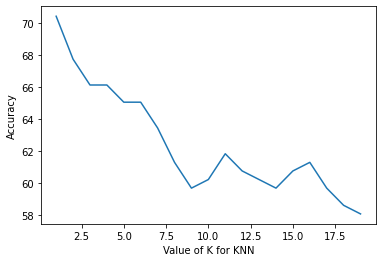

In [ ]:
k_range = range(1, 20)

accuracies = []
X_train,Y_train,X_test,Y_test, test_fonts = better_train_test_split(inter_area_df, 3)

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X=X_train, y=Y_train)

  predictions = knn.predict(X_test)
  actual = Y_test.array
  accuracy = getAccuracy(predictions, actual)*100
  accuracies.append(accuracy)

print(test_fonts)
plt.plot(k_range, accuracies)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy')

It seems that across many font train test split tests the optimal K value is typically around 1 to 5 with a downward trend. 


We think that the reason why a lower K value is better for this problem is because a lot of letters can be very similar to eachother and with larger K values those near by overlaps affect eachother more. An example would be the I L 1 l i classes. At such a low resolution they are nearly identical. 

#Using ensemble methods

In [ ]:
imageDataDf, dataDf = DataFrameImageDataSplit(df)
X, y = imageDataDf.head(3000),dataDf['Char'].head(3000)
# define the model
model = GradientBoostingClassifier()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
# evaluate the model on the dataset
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.599 (0.005)


In [ ]:
model.fit(X, y)

GradientBoostingClassifier()

In [ ]:
prediction = model.predict(imageDataDf)
prediction = prediction
print(prediction.shape)
actual = dataDf['Char']
actual = actual
print(actual.shape)
print(prediction)
incorrect = 0
correct = 0
for i,_ in enumerate(prediction):
  if prediction[i] != dataDf['Char'][i]:
    incorrect += 1
    print('INCORRECT: Predicted Class: %s' % prediction[i] + ' ::: Actual Class: %s' % actual[i])
  else:
    correct += 1
    print('CORRECT: Predicted Class: %s' % prediction[i] + ' ::: Actual Class: %s' % actual[i])

print("Correct", correct)
print("Incorrect", incorrect)
print("Accuracy", correct/(correct + incorrect))

(3906,)
(3906,)
['A' 'j' 'a' ... 'i' '1' 'j']
CORRECT: Predicted Class: A ::: Actual Class: A
CORRECT: Predicted Class: j ::: Actual Class: j
CORRECT: Predicted Class: a ::: Actual Class: a
CORRECT: Predicted Class: i ::: Actual Class: i
CORRECT: Predicted Class: q ::: Actual Class: q
CORRECT: Predicted Class: V ::: Actual Class: V
CORRECT: Predicted Class: 5 ::: Actual Class: 5
CORRECT: Predicted Class: z ::: Actual Class: z
CORRECT: Predicted Class: 9 ::: Actual Class: 9
CORRECT: Predicted Class: v ::: Actual Class: v
CORRECT: Predicted Class: B ::: Actual Class: B
CORRECT: Predicted Class: h ::: Actual Class: h
CORRECT: Predicted Class: d ::: Actual Class: d
CORRECT: Predicted Class: H ::: Actual Class: H
CORRECT: Predicted Class: b ::: Actual Class: b
CORRECT: Predicted Class: q ::: Actual Class: q
CORRECT: Predicted Class: S ::: Actual Class: S
CORRECT: Predicted Class: 5 ::: Actual Class: 5
CORRECT: Predicted Class: t ::: Actual Class: t
CORRECT: Predicted Class: K ::: Actual Cla

##Ensemble method results
The ensemble models have the best results so far compared to the KNN models. However, it took the longest time to train about 30 minutes! We also didn't use that many hyper parameters and it still took that long. Even with the small hyper parameters used we got a very good model.  


**Why do we think this model is so accurate?**

The type of ensemble model we used "GradientBoostingClassifer" Is a boosting model. With boosting each sub model is trained sequentially. Based off the error of each previous model it changes the weights of the input nodes for the next model trained. This is something that we thought about. Not all pixels (inputs) are as valuable as eachother. For example the pixels on the edges are almost always pure white, while the pixels in the middle where the text is centered varies much more. Thus, the pixels in the center are much more important than the pixels on the edges. This boosting model most likely found the best weights for the most and least important pixels.

**The image below doesn't represent the actual weights of each pixel but an example of what it might be like**

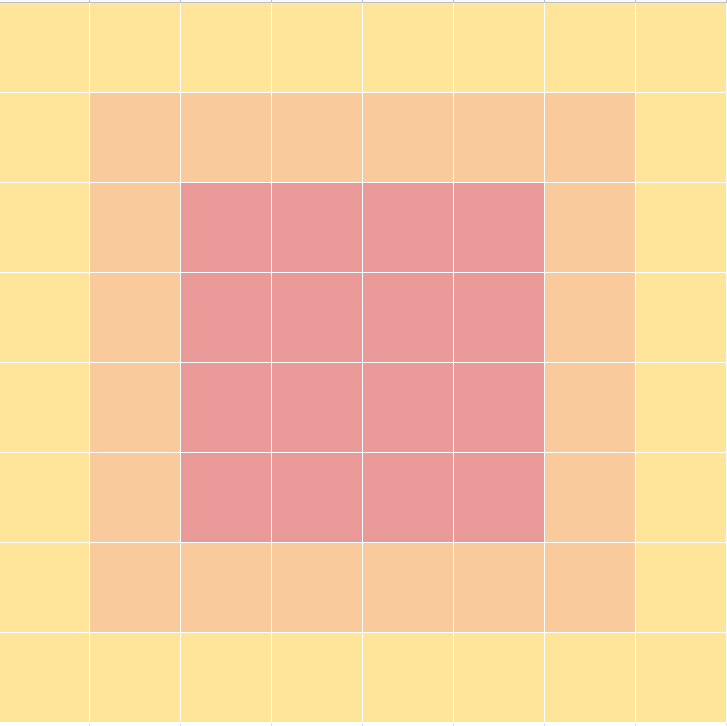

# Using Deep Learning

## Storing image data as a tensor

Tensors allow for easier manipulation and read of the data from images. This speeds up our data model signifigantly for this use case of deep learning

In [ ]:
def image_folder_to_dataframe2_tensor(image_folder_path):
  font_names = []
  original_res = []
  res = []
  downsample = []
  char_type = []
  char = []
  font_size = []
  image_data = []

  for filename in os.listdir(image_folder_path):
    f_path = os.path.join(image_folder_path, filename)
    split = filename.split('_')
    font_names.append(split[0])
    original_res.append(split[1])
    res.append(split[3])
    downsample.append(split[4])
    char_type.append(split[5])
    char.append(split[6])
    font_size.append(split[7])
    image = tf.io.read_file(f_path)
    image = tf.io.decode_png(image).numpy()
    image_data.append(image)


  d = {"Font_Name": font_names, "Original_Resolution": original_res, "Resolution": res, "Downsample": downsample, "Char_Type": char_type, "Char": char, "Font_Size": font_size, "Image_Data": image_data}


  df = pd.DataFrame(data=d)
  return df

## Train-Test Split

Just like our previous models, the deep learning model also needs a train test split. This method is using sklearn's default train test split with a 75%, 25% split. This needs to be updated to out better train test split devised in the KNN model.

In [ ]:
def dl_train_test_split(tensorDf):
  np_config.enable_numpy_behavior()
  x_train, x_test, y_train, y_test = train_test_split(tensorDf['Image_Data'], tensorDf['Char'])
  x_train = x_train.to_numpy()
  x_test = x_test.to_numpy()

  x_train = np.stack( x_train, axis=0 )
  x_train = x_train[:, :, :, 0] # Removing the 4th dimension from the shape, not sure where it's coming from

  x_test = np.stack( x_test, axis=0 )
  x_test = x_test[:, :, :, 0]

  #Display some characters
  plt.figure(figsize = (5,5))
  for index in range(12):
    plt.subplot(3,4,index+1)
    plt.imshow(x_test[index], cmap = 'Greys')
    plt.axis('on') # 'off hides the axis ticks
  plt.tight_layout()
  plt.show()

  #Reshaping the tensor to 64 instead of 8,8
  x_train = x_train.reshape(2929, 64).astype('float32')
  x_test = x_test.reshape(977, 64).astype('float32')

  #Divide x train/test tensors to get pixels values between 0 and 1
  x_train /= 255
  x_test /= 255


  return x_train, x_test, y_train, y_test

## One Hot Encoding

We need to convert our y datasets into 1's and 0's.
To start we need to determine how many classes we need. For a dataset made up of upper and lowercase letters and numbers we have a total of 60 classes.

From this we can convert each letter/number into a binary array of 60.

In [ ]:
# ONE HOT ENCODING
def one_hot_encoding(n_classes, y_train, y_test):
  #n_classes = 60

  y_train = y_train.array
  y_test = y_test.array

  # Really messy way to convert ascii numbers into just the 60 classes we need
  for i,_ in enumerate(y_train):
    y_train[i] = ord(y_train[i])
    if y_train[i] >= 48 and y_train[i] <= 57:
      y_train[i] = y_train[i] - 48
    elif y_train[i] >= 65 and y_train[i] <= 90:
      y_train[i] = y_train[i] - 54
    elif y_train[i] >= 97 and y_train[i] <= 122:
      y_train[i] = y_train[i] - 63

  for i,_ in enumerate(y_test):
    y_test[i] = ord(y_test[i])
    if y_test[i] >= 48 and y_test[i] <= 57:
      y_test[i] = y_test[i] - 48
    elif y_test[i] >= 65 and y_test[i] <= 90:
      y_test[i] = y_test[i] - 54
    elif y_test[i] >= 97 and y_test[i] <= 122:
      y_test[i] = y_test[i] - 63

  # Convert to one-hot-encoding
  y_train = to_categorical(y_train, n_classes)
  y_test = to_categorical(y_test, n_classes)

  return y_train, y_test

## Creating a Deep Learning Model

Now we need to create an appropriate model for our case. We start with an input layer that takes has 64 neurons, one for each pixel in an 8x8 image.

From there we enter the hidden layers. From our experientation a relu activation method works best. For each hidden layer we divide the neurons in half for the weight.

The last layer is our output layer with 60 neurons, one for each possible class.

In [ ]:
def create_model():
  model = Sequential()

  model.add(Dense(64, activation = 'relu', input_shape = (64,)))

  model.add(Dense(64, activation="relu"))

  model.add(Dense(64, activation="relu"))

  model.add(Dense(60, activation = 'softmax'))

  model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
  )
  return model

## Running & Testing the model

Let's create and run our deep learning model

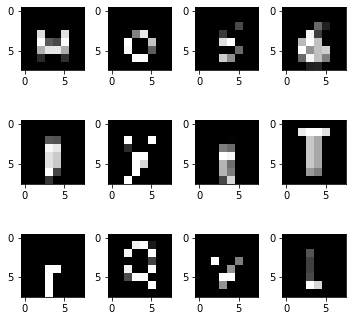

In [ ]:
# Get the dataframe
directory = "/content/drive/MyDrive/Parkside/Machine Learning/Project/Project Image Data/Low_Resolution_Images"
tensorDf = image_folder_to_dataframe2_tensor(directory)

#Train test split
x_train, x_test, y_train, y_test = dl_train_test_split(tensorDf)

#One hot encoding
y_train, y_test = one_hot_encoding(60, y_train, y_test)

#Create the model
model = create_model()

In [ ]:
#Let's run the model!
history = model.fit(x_train, y_train, epochs = 100, verbose = 2, validation_data = (x_test, y_test))

Epoch 1/100
92/92 - 1s - loss: 0.1949 - accuracy: 0.0239 - val_loss: 0.0854 - val_accuracy: 0.0297 - 983ms/epoch - 11ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0847 - accuracy: 0.0389 - val_loss: 0.0847 - val_accuracy: 0.0297 - 276ms/epoch - 3ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0841 - accuracy: 0.0331 - val_loss: 0.0839 - val_accuracy: 0.0287 - 465ms/epoch - 5ms/step
Epoch 4/100
92/92 - 1s - loss: 0.0829 - accuracy: 0.0461 - val_loss: 0.0821 - val_accuracy: 0.0420 - 607ms/epoch - 7ms/step
Epoch 5/100
92/92 - 1s - loss: 0.0807 - accuracy: 0.0574 - val_loss: 0.0798 - val_accuracy: 0.0839 - 619ms/epoch - 7ms/step
Epoch 6/100
92/92 - 1s - loss: 0.0780 - accuracy: 0.0847 - val_loss: 0.0770 - val_accuracy: 0.0860 - 638ms/epoch - 7ms/step
Epoch 7/100
92/92 - 1s - loss: 0.0753 - accuracy: 0.1072 - val_loss: 0.0745 - val_accuracy: 0.0952 - 520ms/epoch - 6ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0722 - accuracy: 0.1437 - val_loss: 0.0716 - val_accuracy: 0.1167 - 256ms/epoch - 3ms/step
Epoch 9

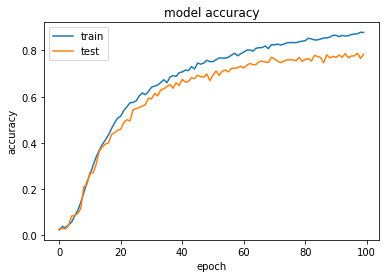

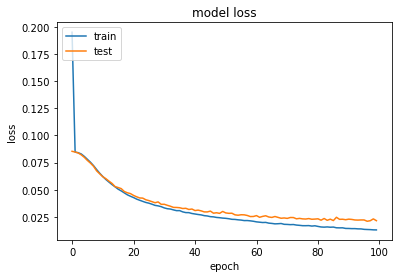

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusion

Deep Learning is a very advanced topic, but from our preliminary models we can tell that Deep Learning works the best for image data. Even though our images are small at 8x8, Deep Learning allows itself to learn continually about the dataset which is perfect for image data